In [34]:
# What allows us to make changes to the z2jh_cost_simulator package
# and workaround a caching of the module, so our changes can be seen.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from z2jh_cost_simulator import simulator

In [1]:
# Now we can work with the simulator object.
# It is time to transition the code from the notebook!
# Node configuration and other configuration

In [5]:
import ipywidgets as widgets
from ipywidgets import Layout, VBox
from IPython.display import display


style = {'description_width': 'initial'}
box_layout = Layout(border='solid',
                    width='50%')


heading = widgets.HTML(value="<b>Select the simulation configuration.</b>")
max_min_nodes = widgets.IntRangeSlider(min=1,
                                      max=10,
                                      step=1,
                                      description='Number of nodes:',
                                      disabled=False,
                                      continuous_update=False,
                                      orientation='horizontal',
                                      readout=True,
                                      style=style)
node_cpu = widgets.IntSlider(min=1,max=16,description="Node CPU",style=style)
node_memory = widgets.FloatSlider(min=10,max=100.0,step =5,description="Node Memory(in GB)",style=style)
user_pod_cpu = widgets.FloatSlider(min=0,max=5,step =.01, description="User pod CPU",style=style)
user_pod_memory = widgets.FloatSlider(min=0,max=5000.0,step=64,description="User pod Memory(in MB)",style=style)
cost_per_month = widgets.FloatSlider(min=0,max=150.0,step=5.5,description="Cost per month",style=style)
node_configurations = [heading,max_min_nodes,node_cpu,user_pod_cpu,node_memory,user_pod_memory,cost_per_month]
pod_culling_max_inactivity_time = 7
pod_culling_max_lifetime = 3
VBox(node_configurations,layout = box_layout)

In [ ]:

configurations_for_simulator = {'min_nodes': max_min_nodes.lower,'max_nodes':max_min_nodes.upper,
                                'node_cpu': node_cpu.value ,'node_memory': node_memory.value,
                                'user_pod_cpu':user_pod_cpu.value,'user_pod_memory': user_pod_memory.value,
                                'cost_per_month': cost_per_month.value,
                                'pod_inactivity_time':3,
                                'pod_max_lifetime':7 }
simulator = simulator.Simluation(configurations_for_simulator)


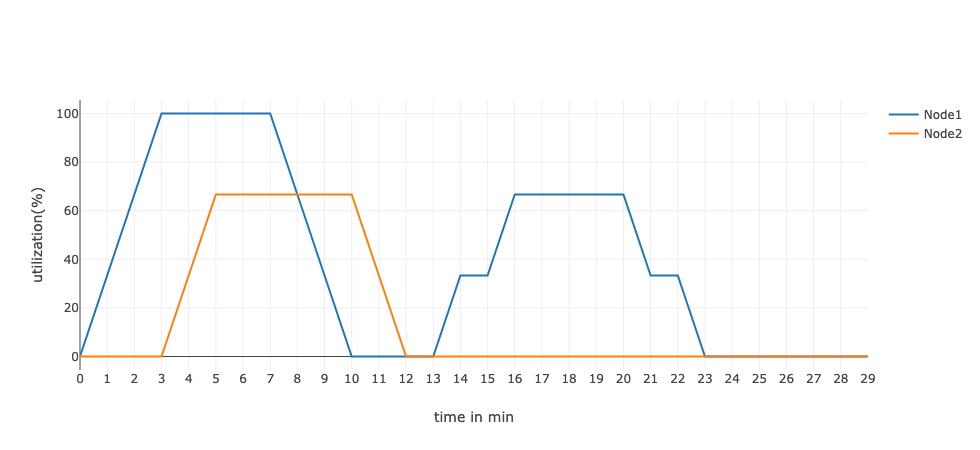

In [7]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode , plot, iplot

#the user activity

user_activity = [[0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                 [0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,1,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0]]

simulator = simulator.Simulation(30,user_activity)
simulator.run_simulation()
